In [ ]:
import os
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load preprocessed dataset
df = pd.read_parquet("../data/processed_emoji_dataset.parquet")

# Convert embeddings to float32 numpy arrays
df["combined_embedding"] = df["combined_embedding"].apply(lambda x: np.array(x, dtype=np.float32))

In [ ]:
# Custom Dataset Class
class EmojiDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.dataframe.iloc[idx]["combined_embedding"]).float()
        image_tensor = torch.load(self.dataframe.iloc[idx]["image_path"]).float()
        return embedding, image_tensor

In [ ]:
# Create DataLoader
dataset = EmojiDataset(df)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [ ]:
for embeddings, images in dataloader:
    print(embeddings.shape, images.shape)
    break


torch.Size([64, 384]) torch.Size([64, 3, 16, 16])


In [ ]:
# Define U-Net Model for 16×16 Images
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Initialize Model
model = UNet().to(device)
print("U-Net Model Created!")
# Diffusion Process
class Diffusion:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.num_timesteps = num_timesteps
        self.beta = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)

    def add_noise(self, x0, t):
        noise = torch.randn_like(x0).to(device)

        # Compute the max value per image correctly
        max_noise, _ = torch.max(torch.abs(noise.view(noise.shape[0], -1)), dim=1)
        max_noise = max_noise.view(-1, 1, 1, 1)  # Reshape for broadcasting
        max_noise[max_noise == 0] = 1e-8  # Avoid division by zero

        noise = noise / max_noise  # Normalize noise to [-1, 1]

        alpha_t = self.alpha_cumprod[t].view(-1, 1, 1, 1).to(device)
        noisy_x = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
        noisy_x = torch.clamp(noisy_x, -1, 1)

        return noisy_x, noise

diffusion = Diffusion()
print("Diffusion Process Initialized!")

U-Net Model Created!
Diffusion Process Initialized!


In [ ]:
print("Checking model outputs before training...")
test_noise = torch.randn(1, 3, 16, 16).to(device)
test_output = model(test_noise)
print("Model output - Min:", test_output.min().item(), "Max:", test_output.max().item())


Checking model outputs before training...
Model output - Min: -0.0233506727963686 Max: 0.02689378708600998


In [ ]:
# Training Loop
optimizer = optim.Adam(model.parameters(), lr=2e-4)
loss_fn = nn.MSELoss()
loss_values = []
epochs = 30

for epoch in range(epochs):
    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")

    for embeddings, images in loop:
        images = images.to(device)

        t = torch.randint(0, 1000, (images.shape[0],)).to(device)
        noisy_images, noise = diffusion.add_noise(images, t)

        predicted_noise = model(noisy_images)
        loss = loss_fn(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        loss_values.append(loss.item())
print("Training Completed!")

# for epoch in range(epochs):
#     loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")

#     for embeddings, images in loop:
#         images = images.to(device)

#         t = torch.randint(0, 1000, (images.shape[0],)).to(device)
#         noisy_images, noise = diffusion.add_noise(images, t)

#         predicted_noise = model(noisy_images)
#         predicted_noise = torch.clamp(predicted_noise, -1, 1)

#         loss = loss_fn(predicted_noise, noise)

#         # Print debug information
#         if torch.isnan(loss):
#             print("⚠️ NaN detected! Debugging...")
#         print(f"Noisy Images - Min: {noisy_images.min()} Max: {noisy_images.max()}")
#         print(f"Noise - Min: {noise.min()} Max: {noise.max()}")
#         print(f"Predicted Noise - Min: {predicted_noise.min()} Max: {predicted_noise.max()}")

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         loop.set_postfix(loss=loss.item())
        


Epoch [5/5]: 100%|██████████| 196/196 [00:08<00:00, 22.65it/s, loss=0.0257]

Training Completed!


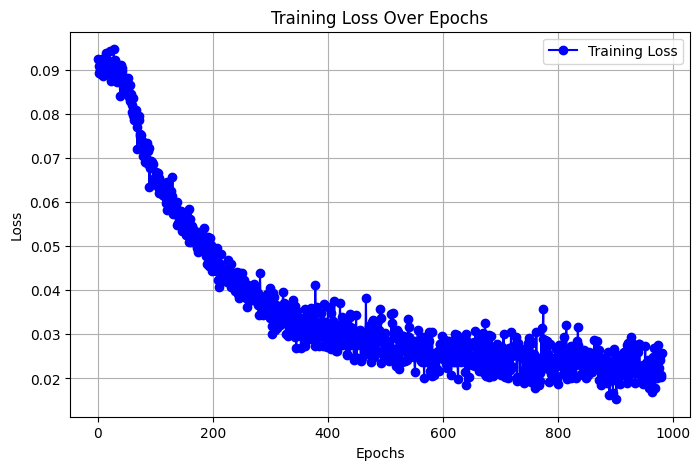

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
@torch.no_grad()
def sample(num_images=5):
    model.eval()
    images = torch.randn(num_images, 3, 16, 16).to(device)  # Start from noise

    for t in reversed(range(1000)):  # Reverse diffusion
        alpha_t = diffusion.alpha_cumprod[t].view(-1, 1, 1, 1).to(device)
        beta_t = diffusion.beta[t].view(-1, 1, 1, 1).to(device)

        noise_pred = model(images)  # Predict noise

        # Correct denoising step
        images = (images - (1 - alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()

        if t > 0:
            images += beta_t.sqrt() * torch.randn_like(images)  # Add noise

        # Debug: Visualize steps
        if t % 200 == 0:
            plt.imshow(images[0].cpu().permute(1, 2, 0).numpy())
            plt.title(f"Step {t}")
            plt.axis("off")
            plt.show()

    return images




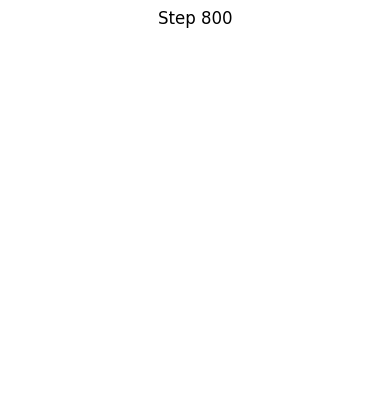

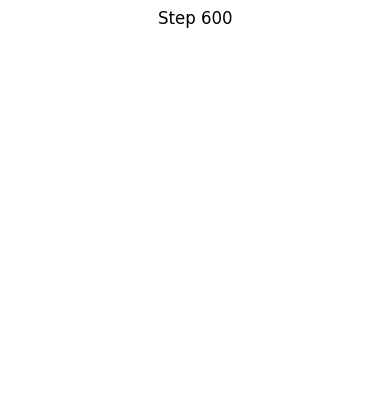

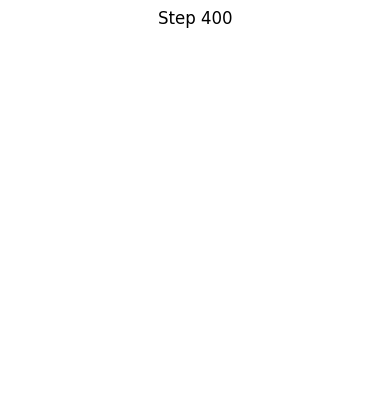

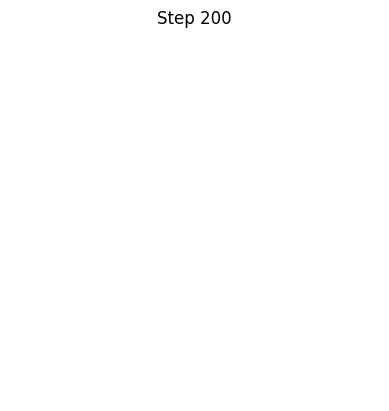

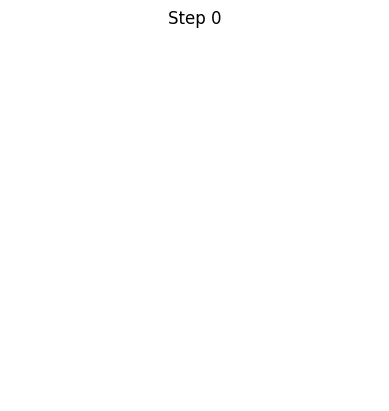

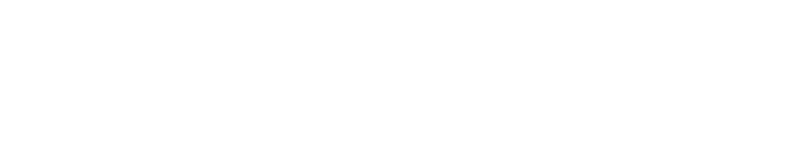

In [ ]:
# Generate images
generated_images = sample(5).cpu().permute(0, 2, 3, 1)
generated_images = (generated_images + 1) / 2  # Convert from [-1,1] to [0,1]

# Display output
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i])
    ax.axis("off")
plt.show()

In [ ]:
@torch.no_grad()
def sample(num_images=5):
    model.eval()
    images = torch.randn(num_images, 3, 16, 16).to(device)  # 16×16 image size

    for t in reversed(range(1000)):  # Reverse process
        alpha_t = diffusion.alpha_cumprod[t].view(-1, 1, 1, 1).to(device)
        noise_pred = model(images)

        # Add epsilon to prevent NaN errors
        images = (images - torch.sqrt(1 - alpha_t + 1e-8) * noise_pred) / torch.sqrt(alpha_t + 1e-8)

        if t > 0:
            images += torch.sqrt(diffusion.beta[t]) * torch.randn_like(images)

    return images


In [ ]:
images = sample(5).cpu().permute(0, 2, 3, 1)
print("Min:", images.min(), "Max:", images.max())  # Check if the values are meaningful


Min: tensor(nan) Max: tensor(nan)


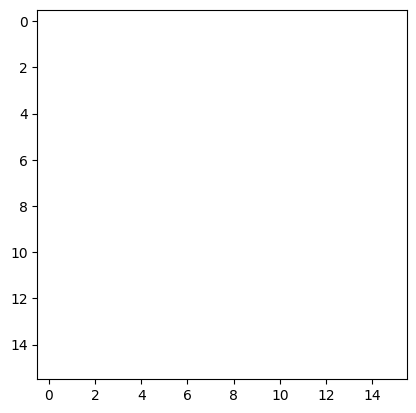

In [ ]:
generated_images = sample(5).cpu().permute(0, 2, 3, 1)
generated_images = torch.clamp(generated_images, 0, 1)  # Ensure pixel values are in [0,1]
plt.imshow(generated_images[0])  # Display a single image
plt.show()


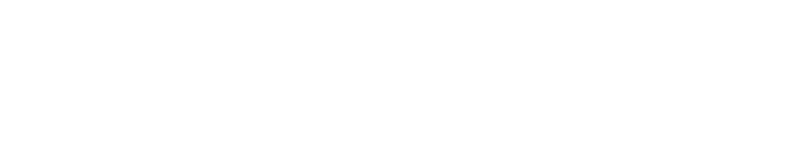

In [ ]:
# Generate emojis
generated_images = sample(5).cpu().permute(0, 2, 3, 1) * 0.5 + 0.5  # Normalize back

# Display generated emojis
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i])
    ax.axis("off")
plt.show()